<a href="https://colab.research.google.com/github/birajsth/MachineLearning-with-tensorflow/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification
Building an image classifier from scratch to distinguish photos of cats from photos of dogs using Conbolutional Neural Network.


**Explore the Example Data**

The 2,000 images used in this exercise are excerpted from ' Dogs vs Cats' dataset available on kaggle, which contains 25,000 images.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-05-11 08:02:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  65.8MB/s    in 1.0s    

2019-05-11 08:02:57 (65.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


The contents of the .zip are extracted to the vase directory /tmp/cats_and_dogs_filtered, which contains train and  validation subdirectories for the training and validation datasets, which in turn each contain cats and dogs subdirectories. Let's define each of these directories:

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directories with our training cat and dog pictures.
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directories with our validation cat and dog pictures.
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')



In [0]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])



['cat.451.jpg', 'cat.436.jpg', 'cat.816.jpg', 'cat.91.jpg', 'cat.673.jpg', 'cat.300.jpg', 'cat.873.jpg', 'cat.845.jpg', 'cat.958.jpg', 'cat.204.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [0]:
% matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph;
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0


Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

In [0]:
# set up matplotlib fig, and size it to fit 4x4 pics.
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('OFF')
  
  img = mpimg.imread(img_path)
  plt.imshow(img)
  
plt.show

## Building a Small Convnet from scratch to get to 72% accuracy
The images that will fo into our convnet are 150x150 color imagesl

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules.
Our convolutions operate on 3x3 windows and our maxpooling layres operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

Note: This is a configuration that is widely used and known to work for image classification. Also, since we have relatively few training examples(1,000),  using just three convolutional modules keeps the model small, which lowers the risk of overfitting.


In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model


In [0]:
# Our input feature map is 150x150x3 for the image pixels, and 3 for the 
# three color channels: R, G, and B.
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)


On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem , i.e a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0.)

In [0]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layer
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Adding a dropout rate 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a singel node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create Model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + 
# fully connected layer + sigmoid output layer
model = Model(img_input, output)

Let's summarize the model architecture:

In [0]:
model.summary()

### Compile

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing
Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to out network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. In our case, we will preprocess our images by normalizing he pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
# Adding rotation_range, width_shift_range, height_shift_range, shear_range,
# zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir, # source directory for training images
    target_size=(150, 150), # all images will be resized to 150x150
    batch_size=20,
    # since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images.


In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, # 2000 images = batch_size * steps
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50, # 1000 images = batch_size * steps
    verbose=2)


Epoch 1/15
50/50 [==============================] - 14s 276ms/step - loss: 0.6263 - acc: 0.6640
 - 79s - loss: 0.7800 - acc: 0.5565 - val_loss: 0.6263 - val_acc: 0.6640
Epoch 2/15
50/50 [==============================] - 13s 259ms/step - loss: 0.5992 - acc: 0.7070
 - 75s - loss: 0.6200 - acc: 0.6665 - val_loss: 0.5992 - val_acc: 0.7070
Epoch 3/15
50/50 [==============================] - 13s 256ms/step - loss: 0.5861 - acc: 0.7020
 - 74s - loss: 0.5562 - acc: 0.7190 - val_loss: 0.5861 - val_acc: 0.7020
Epoch 4/15
50/50 [==============================] - 13s 260ms/step - loss: 0.5562 - acc: 0.7220
 - 75s - loss: 0.4994 - acc: 0.7565 - val_loss: 0.5562 - val_acc: 0.7220
Epoch 5/15
50/50 [==============================] - 13s 270ms/step - loss: 0.5479 - acc: 0.7510
 - 75s - loss: 0.4141 - acc: 0.7990 - val_loss: 0.5479 - val_acc: 0.7510
Epoch 6/15
50/50 [==============================] - 13s 259ms/step - loss: 0.6208 - acc: 0.7050
 - 75s - loss: 0.3269 - acc: 0.8690 - val_loss: 0.6208 - va

### Visualizing Intermediate Representations
To get a feel for what kind of features our convent has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convent.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


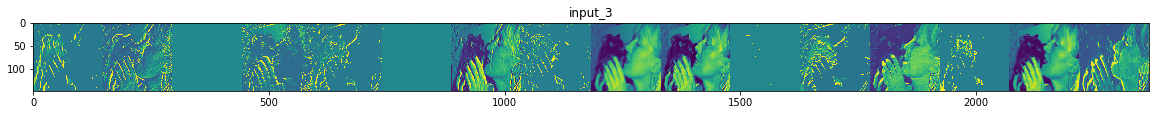

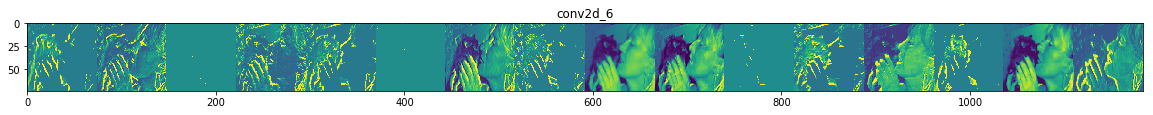

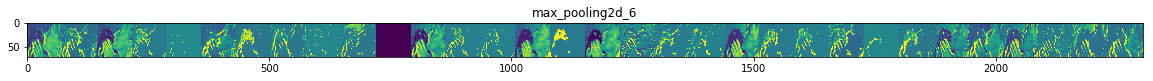

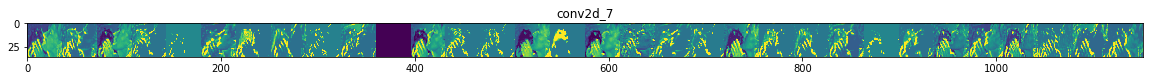

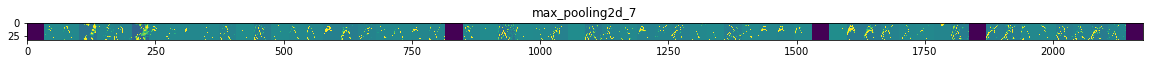

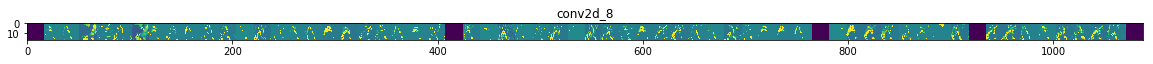

In [0]:
import numpy as np 
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prerpare a random input of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150)) # this is a PIL image
x = img_to_array(img) # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all 
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1] # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]# We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

### Evaluating Accuracy and Loss for the Model


Text(0.5, 1.0, 'Training and validation loss')

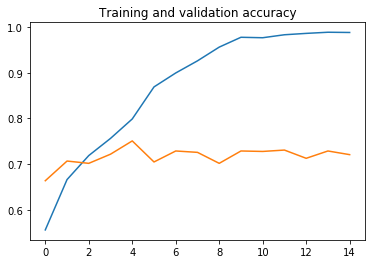

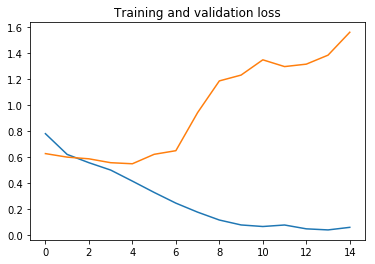

In [0]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

### Clean Up
Before running the next exercise, run the following cell to teriminate the kernal and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)